<a href="https://colab.research.google.com/github/udupa-varun/pyimagesearch_uni/blob/main/nlp/101/compare_bow_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/comparison-between-BOW-and-W2V/comparison-between-BOW-and-W2V.zip
!unzip -qq comparison-between-BOW-and-W2V.zip
%cd comparison-between-BOW-and-W2V

--2024-01-15 20:14:23--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/comparison-between-BOW-and-W2V/comparison-between-BOW-and-W2V.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.187.18, 52.92.187.242, 3.5.78.19, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.187.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 639753 (625K) [binary/octet-stream]
Saving to: ‘comparison-between-BOW-and-W2V.zip’

comparison-between- 100%[===================>] 624.76K   894KB/s    in 0.7s    

2024-01-15 20:14:24 (894 KB/s) - ‘comparison-between-BOW-and-W2V.zip’ saved [639753/639753]

/content/comparison-between-BOW-and-W2V


In [2]:
!pip install plotly -qq

In [3]:
import os

import tensorflow as tf
tf.random.set_seed(42)



from sklearn.manifold import TSNE
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd


from pyimagesearch import config
from pyimagesearch.BOWmodel import build_shallow_net
from pyimagesearch.data_processing import (
    preprocess, prepare_tokenizerBOW, prepare_tokenizerW2V
)

### Prepare the dataset

In [5]:
# prepare stop-words using NLTK
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words("english")

# init df from csv
data_df = pd.read_csv("datadf.csv")

# preprocess the dataframe
processed_df = preprocess(data_df, stop_words)

# store number of classification heads
num_classes = len(processed_df["sentiment"].unique())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/content/comparison-between-BOW-and-W2V/pyimagesearch/data_processing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentDf["sentence"].iloc[num] = newSent


### Train Bag of Words model

Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 1.3768 - accuracy: 0.3333
Epoch 2/30
1/1 [==============================] - 0s 26ms/step - loss: 1.2441 - accuracy: 0.6667
Epoch 3/30
1/1 [==============================] - 0s 20ms/step - loss: 1.1370 - accuracy: 0.8333
Epoch 4/30
1/1 [==============================] - 0s 17ms/step - loss: 1.0460 - accuracy: 0.9667
Epoch 5/30
1/1 [==============================] - 0s 22ms/step - loss: 0.9619 - accuracy: 0.9667
Epoch 6/30
1/1 [==============================] - 0s 14ms/step - loss: 0.8835 - accuracy: 0.9667
Epoch 7/30
1/1 [==============================] - 0s 13ms/step - loss: 0.8091 - accuracy: 0.9667
Epoch 8/30
1/1 [==============================] - 0s 14ms/step - loss: 0.7381 - accuracy: 0.9667
Epoch 9/30
1/1 [==============================] - 0s 14ms/step - loss: 0.6694 - accuracy: 0.9667
Epoch 10/30
1/1 [==============================] - 0s 16ms/step - loss: 0.6044 - accuracy: 0.9667
Epoch 11/30
1/1 [==============

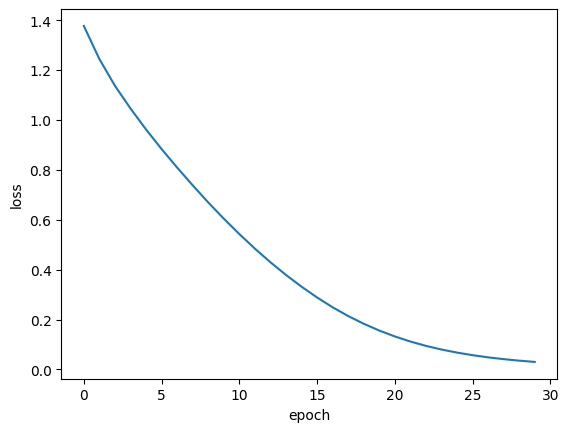

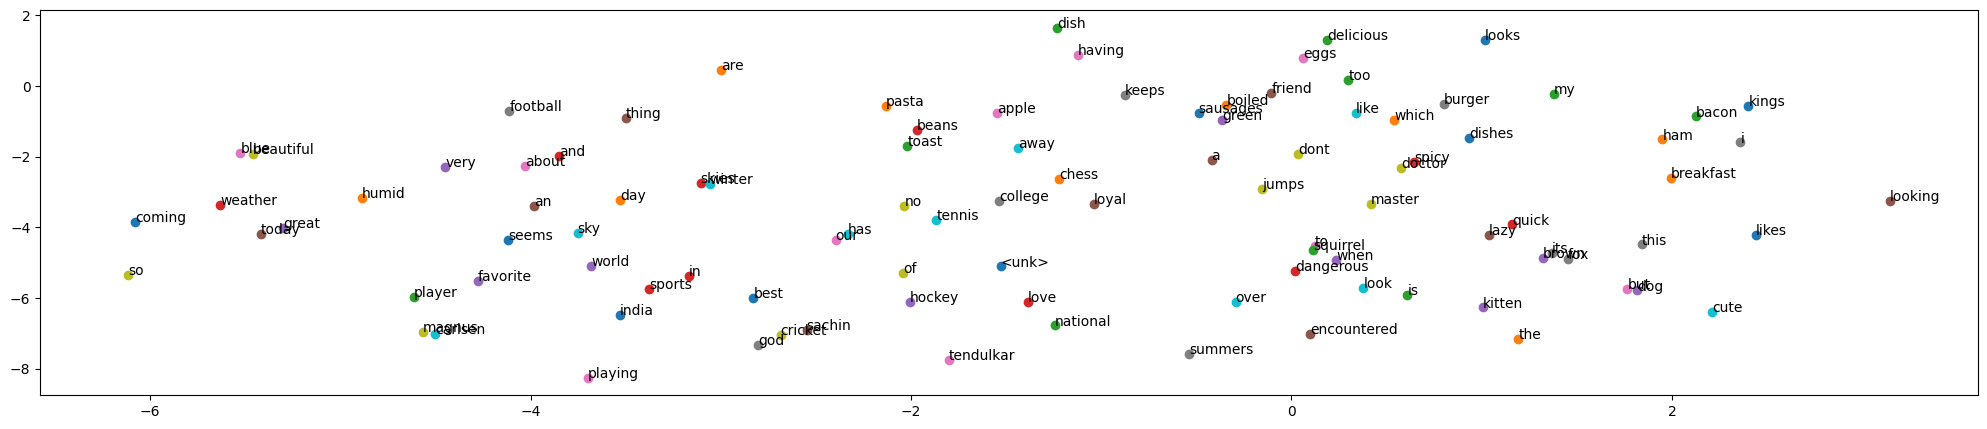

In [11]:
# create tokenizers for data and labels
(tokenizer_data, tokenizer_labels) = prepare_tokenizerBOW(
    processed_df, topWords=106
)

# create integer sequences of data using tokenizer
train_seqs = tokenizer_data.texts_to_sequences(processed_df["sentence"])
train_labels = tokenizer_labels.texts_to_sequences(processed_df["sentiment"])

# create the BOW feature representation
encoded_docs = tokenizer_data.texts_to_matrix(
    processed_df["sentence"].values,
    mode="count"
)

# adjust train label indices for training
train_labels = np.array(train_labels)
for num in range(len(train_labels)):
    train_labels[num] = train_labels[num] - 1

# init model for training
BOW_model = build_shallow_net(
    inputDims=tokenizer_data.num_words - 1,
    numClasses=num_classes
)

# fit data into model and store training details
history = BOW_model.fit(
    encoded_docs[:, 1:],
    train_labels.astype("float32"),
    epochs=config.EPOCHS
)

if not os.path.exists(config.OUTPUT_PATH):
    os.makedirs(config.OUTPUT_PATH)


# plot loss for BOW model
print("[INFO] plotting loss...")
plt.plot(history.history["loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig(config.BOW_LOSS)

# get weights for first model layer
representations_BOW = BOW_model.get_weights()[0]

# apply dim reduction using TSNE
tsne_embed = TSNE(n_components=2).fit_transform(representations_BOW)

idx_count = 1

# init figure
plt.figure(figsize=(25,5))

# loop over tsne embeddings and plot corresponding words
print("[INFO] Plotting TSNE embeddings...")
for (word, embedding) in tsne_embed[:100]:
    plt.scatter(word, embedding)
    plt.annotate(tokenizer_data.index_word[idx_count], (word, embedding))
    idx_count += 1
plt.savefig(config.BOW_TSNE)

### Train Word2Vec model

[INFO] Starting Word2Vec training...


100%|██████████| 1000/1000 [09:21<00:00,  1.78it/s]


[INFO] plotting loss...


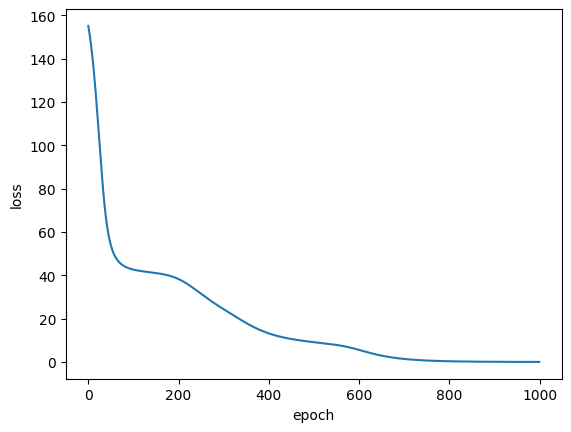

In [7]:
# create tokenizers for data and labels
tokenizer_data = prepare_tokenizerW2V(processed_df, topWords=200)

# create integer sequences of data using tokenizer
train_seqs = tokenizer_data.texts_to_sequences(processed_df["sentence"])
train_labels = tokenizer_data.texts_to_sequences(processed_df["sentiment"])


# create rep matrices as variable tensors
context_vector_matrix = tf.Variable(
    np.random.rand(200, config.EMBEDDING_SIZE)
)
center_vector_matrix = tf.Variable(
    np.random.rand(200, config.EMBEDDING_SIZE)
)

# init optimizer and list for loss
optimizer = tf.optimizers.Adam()
loss_list = list()

# loop over the training epochs
print("[INFO] Starting Word2Vec training...")
for iter in tqdm(range(config.ITERATIONS)):
    # initialize the loss per epoch
    loss_per_epoch = 0

    for (idxs, target) in zip(train_seqs, train_labels):
        # convert label to int
        target = target[0]

        # init gradient tape
        with tf.GradientTape() as tape:
            combined_context = 0

            # update combined context with each index
            for (count, idx) in enumerate(idxs):
                combined_context += context_vector_matrix[idx, :]

            # standardize
            combined_context /= len(idxs)

            output = tf.matmul(
                center_vector_matrix,
                tf.expand_dims(combined_context, 1)
            )

            # calculate softmax output and grab relevant index for loss
            soft_out = tf.nn.softmax(output, axis=0)
            loss = soft_out[target]
            log_loss = -tf.math.log(loss)

        # update loss per epoch
        loss_per_epoch += log_loss.numpy()

        # apply gradients to embedding matrices
        grad = tape.gradient(
            log_loss, [context_vector_matrix, center_vector_matrix]
        )
        optimizer.apply_gradients(
            zip(grad, [context_vector_matrix, center_vector_matrix])
        )

    # update loss list
    loss_list.append(loss_per_epoch)

if not os.path.exists(config.OUTPUT_PATH):
    os.makedirs(config.OUTPUT_PATH)


# plot loss for BOW model
print("[INFO] plotting loss...")
plt.plot(loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig(config.W2V_LOSS)




[INFO] Plotting TSNE embeddings...


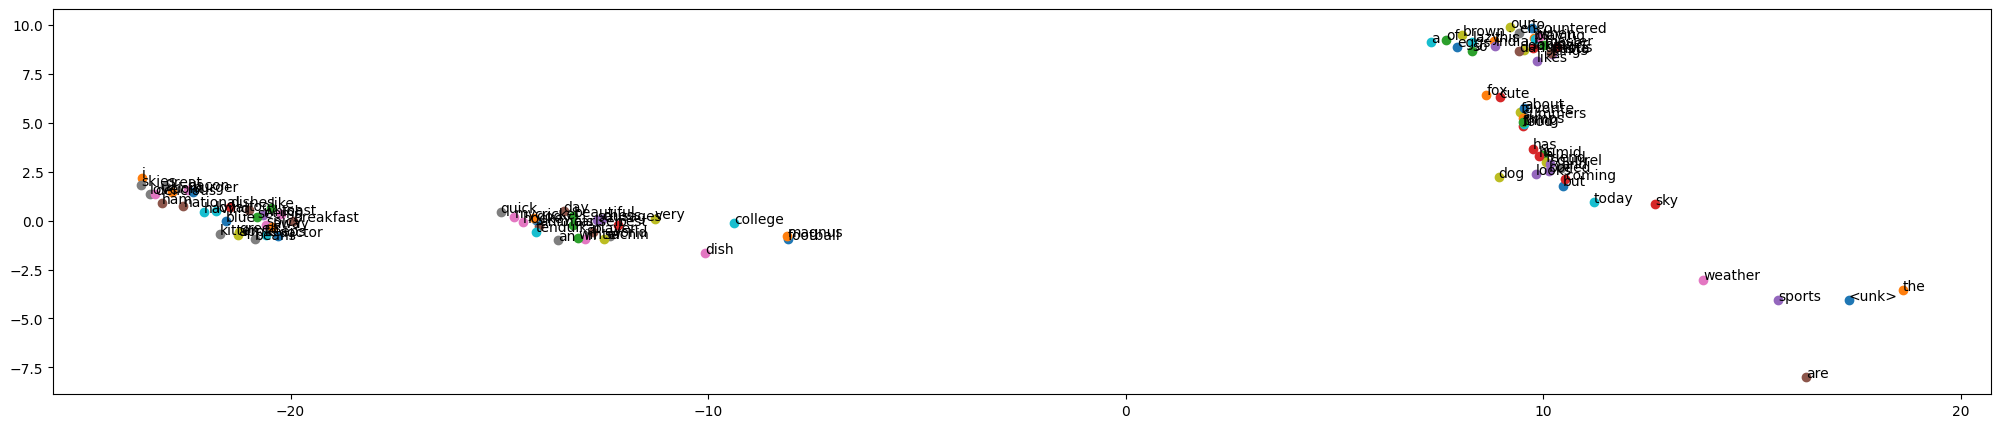

In [8]:
# apply dim reduction using TSNE
tsne_embed = (
    TSNE(n_components=2)
    .fit_transform(context_vector_matrix.numpy())
)

idx_count = 1

# init figure
plt.figure(figsize=(25,5))

# loop over tsne embeddings and plot corresponding words
print("[INFO] Plotting TSNE embeddings...")
for (word, embedding) in tsne_embed[:100]:
    plt.scatter(word, embedding)
    plt.annotate(tokenizer_data.index_word[idx_count], (word, embedding))
    idx_count += 1
plt.savefig(config.W2V_TSNE)